## Topic Modeling
- 문서안의 주제를 찾아내는 목적의 텍스트마이닝 기법
- 문서안의 모든 내용을 읽고, 주제를 파악하는것이 시간과 노력이이 오래 걸리고 많이 소모되기 때문
- 의미가 없는 단어는 무시하고 ( Stop Word 제거 ) , 의미있는 단어들을 추출해서 주요 주제를 찾는 방법

### 토픽 모델링에 자주 사용되는 기법에는 LSA (Latent Semantic Analysis) 와 LDA(Latent Dirichlet Allocation)
  
    
### 1. 잠재 의미 분석 ( LSA : Latent Semantic Analysis )
- 카운트 벡터화 / TF-IDF는 문맥을 고려하지않고, 빈도수를 기준으로 행렬을 만들었다.
- 하지만 이러한 방식으로는, 문서의 주제를 알 수 없다.
- 이를 위해 특이값 분해(SVD분해)를 사용해서 문서의 숨어있는 의미를 추출한다.

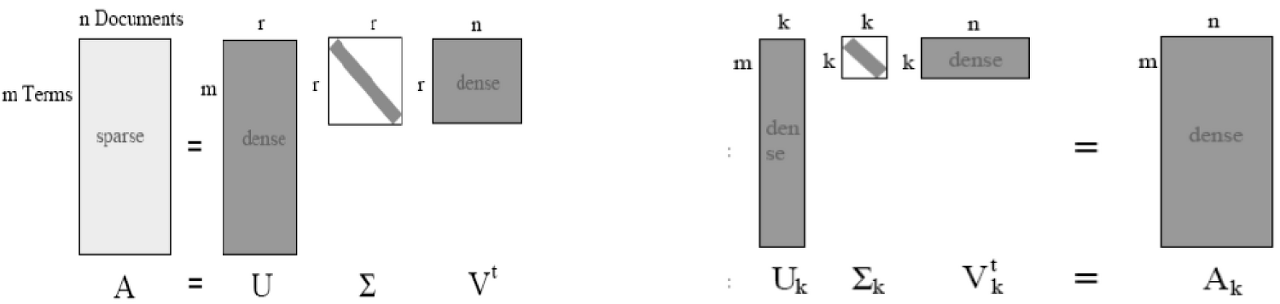

n개의 문서에 포함된, 중복제거한 단어의 총 갯수가 m개이다.
이를 기반으로 DTM(문서-단어행렬)을 만들면 (mxn) 크기의 행렬 A가 된다.  

이 행렬 A를 특이값 분해하면 행렬 U ∑ Vt 가 된다.  

이 때, ∑는 총 r개의 특이값을 갖는다.
  
사용자가 r보다 작은 k를 설정하고, k만큼의 특이값만 남기고, (kxk) 크기를 갖는 ∑k를 만든다.
  

특이값 분해를 하면 행렬의 대각원소는 크기순으로 정렬되기 때문에 k개만 남기고 잘라주면, 특이값 k개만 남게 된다.
  
이와 대응되게 U와 Vt행렬에 대해서도 k개만 남기고 (mxk) 크기를 갖는 Uk와 (kxn) 크기를 갖는 Vkt를 만들어준다.
  
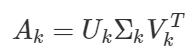

이렇게 만든 Ak에는 중요한 토픽만 남게 된다.
A행렬과 Ak행렬의 크기는 (mxn) 으로 같지만  
A행렬에는 불필요한 토픽이 많이 포함되어있고, Ak에는 문서의 잠재의미(주요 주제, 중요 단어)가 들어있는 상태이다.


In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [1]:
# 11314개의 문서 존재

In [3]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
# 정규 표현식을 이용해, 알파벳 이외의 문자는 제거, 모두 소문자로, 3글자 이하는 제거

news_df = pd.DataFrame({'document' : documents})

news_df['clean_doc'] = news_df['document'].replace("[^a-zA-Z#']", ' ')# a-z, A-Z 가 아니면 일단 공백으로(아래에서 이유 나옴)

news_df['clean_doc'] = news_df['clean_doc'].apply( lambda x : ' '.join( [ sep_x for sep_x in x.split() if len(sep_x) > 3 ] ))# clean_doc 의 원소를 공백 기준으로 분리해서 3보다 작으면 추가안함(제거함)  

news_df['clean_doc'] = news_df['clean_doc'].apply( lambda x : x.lower() )


In [10]:
news_df

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased. what disagr...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...","yeah, expect people read faq, etc. actually ac..."
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...","well, will have change scoring playoff pool. u..."
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will ...","danny rubenstein, israeli journalist, will spe..."
11310,\n,
11311,\nI agree. Home runs off Clemens are always m...,agree. home runs clemens always memorable. kin...
11312,I used HP DeskJet with Orange Micros Grappler ...,used deskjet with orange micros grappler syste...


In [12]:
# TF_IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features = 1000,
    max_df = 0.5,
    smooth_idf =  True
)
X = vectorizer.fit_transform(news_df)

In [13]:
X

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [16]:
X1 = vectorizer.fit_transform(news_df['clean_doc'])

In [17]:
X1

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 264014 stored elements in Compressed Sparse Row format>

In [19]:
# 11314 개의 문서에서 1000개의 단어만 활용하여 문서-단어행렬(DTM)을 만들었으니, 여기서 Truncated 특이값분해(SVD)를 통해 토픽 모델링을 해보면
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD( n_components = 20, algorithm = 'randomized', n_iter = 100, random_state = 122 )

svd_model.fit(X1)

svd_model.components_.shape

(20, 1000)

In [20]:
# 11314x1000 -> 20 x 1000

In [21]:
svd_model.singular_values_

array([17.77231362, 10.01217433,  8.17843518,  7.93325259,  7.82783898,
        7.5498085 ,  7.48085388,  7.16625408,  6.98569092,  6.94167155,
        6.81107328,  6.79005113,  6.70874705,  6.53757432,  6.46489843,
        6.38885386,  6.32663276,  6.27020511,  6.23181691,  6.13561725])

In [22]:
terms = vectorizer.get_feature_names()
len(terms)

1000

In [24]:
n = 9
components = svd_model.components_
for index, topic in enumerate(components):
  #print('Topic %d: '%(index + 1), [terms[i] for i in topic.argsort()[: -n - 1: -1]])
  print('Topic {}: {}'.format(index+1, [ terms[i] for i in topic.argsort()[: -n -1: -1]]))

Topic 1: ['just', 'don', 'like', 'know', 'people', 'think', 'does', 'good', 'time']
Topic 2: ['thanks', 'windows', 'card', 'drive', 'mail', 'file', 'edu', 'advance', 'files']
Topic 3: ['game', 'team', 'year', 'games', 'drive', 'season', 'good', 'players', 'play']
Topic 4: ['edu', 'thanks', 'mail', 'game', 'team', 'email', 'com', 'send', 'games']
Topic 5: ['know', 'does', 'thanks', 'don', 'just', 'like', 'game', 'advance', 'anybody']
Topic 6: ['drive', 'edu', 'thanks', 'scsi', 'drives', 'hard', 'know', 'does', 'mail']
Topic 7: ['just', 'edu', 'don', 'like', 'soon', 'bike', 'com', 'cs', 'want']
Topic 8: ['chip', 'government', 'encryption', 'like', 'clipper', 'keys', 'phone', 'data', 'key']
Topic 9: ['don', 'know', 'edu', 'does', 'think', 'chip', 'card', 'government', 'encryption']
Topic 10: ['does', 'card', 'just', 'video', 'like', 'edu', 'monitor', 'jesus', 'god']
Topic 11: ['just', 'drive', 'does', 'file', 'game', 'team', 'files', 'edu', 'israel']
Topic 12: ['like', 'drive', 'does', 'f